Step #1: Translate Rainfall to Crop Yields

Here we use the LASSO regression model to compute the sensitivity of crop yields to growing-season rainfall.

In [1]:
#############################
####### Load packages ####### 
#############################

# Numerical computing
import numpy as np
import pandas as pd
# Statistical analysis
import scipy.stats as stats
# Geospatial data
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs          
# Plotting
import proplot as pplt # Similar to Matplotlib
import seaborn as sns
# SKLEARN for regression modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.utils import resample
# Parallel computing
from joblib import Parallel, delayed
# Ignore warnings
import warnings; warnings.filterwarnings("ignore")

#############################
######## Questions ##########
#? Do we need to include the temperature into the regression model? Yes, we do.
#! The phenology information of soybean in Brazil can be updated later (see https://zenodo.org/records/6678538).

In [2]:
def align_data_with_growth(df, var):

    """ 
    Here, we will convert the 1D data into the shape (Years x Months, Y x M) considering the crop's growth period (e.g., Sep.-- Dec. in the last year to Jan.--Feb. in the current year, in the case of soybean in Brazil).  
    #! Note that we align the monthly precipitation to the soybean growth year. 
    """
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
   
    # Convert the Y x M
    start = '1981-01-01'; end = '2018-12-31' #! Climate in the year 1981 is used to align the soybean in the year 1982
    # Create the mask 
    mask = (df.index >= start) & (df.index <= end)
    df   = df[mask]
    # Arrange the data
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df = pd.DataFrame(df.values.reshape(int(df.shape[0]/12), 12), columns=months, index=pd.date_range(start=start, end=end, freq='YS'))
    
    # Align the growing season
    ## Sep. to Dec. last year
    previous_df = df.loc[:, 'Aug':'Dec'].shift(periods=1, freq='YS', fill_value=np.nan, axis='rows')
    ## Jan. to Apr. this year
    this_df     = df.loc[:, 'Jan':'Mar'].shift(periods=0, freq='YS', fill_value=np.nan, axis='rows')
    ## concat two dataframes
    df = pd.concat([previous_df, this_df], axis='columns')
    ## drop nan columns
    df = df.dropna()

    df.columns = var + '_' + df.columns

    return df

# Define the input variables for the LASSO regression model
def crop_growth_period(prec, temp):

    """
    Pre-season: Aug. and Sep.
    Early-season: Oct. and Nov.
    Mid-season: Dec. and Jan.
    Late-season: Feb. and Mar.
    """

    # define the input variable 
    df = pd.DataFrame(index=prec.index)

    #---- Precipitation ----
    df['P_Pre']   = prec['P_Aug'] + prec['P_Sep']
    df['P_Early'] = prec['P_Oct'] + prec['P_Nov']
    df['P_Mid']   = prec['P_Dec'] + prec['P_Jan']
    df['P_Late']  = prec['P_Feb'] + prec['P_Mar'] 

    #---- Precipitation square terms ----
    # df['P_Pre_sq']   = df['P_Pre'] ** 2
    # df['P_Early_sq'] = df['P_Early'] ** 2
    # df['P_Mid_sq']   = df['P_Mid'] ** 2
    # df['P_Late_sq']  = df['P_Late'] ** 2
    
    #---- Temperature ----
    df['Grow_T'] = temp.mean(axis=1)

    #---- Year ----
    df['Year'] = np.arange(1982,2018+1,1)
    df['Year_sq'] = df['Year'] ** 2
    
    return df

# Data Preparation and Analysis

In [3]:
# read shapefiles
gdf = gpd.read_file('../01-mods/Brazil_states.shp')
gdf = gdf.set_crs(ccrs.PlateCarree().proj4_init)

gdf.head(3)

,PCODE,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE,geometry
0,12,Brazil,Brasil,BR,Acre,BR12,"MULTIPOLYGON (((-68.877 -11.020, -68.880 -11.0..."
1,16,Brazil,Brasil,BR,Amapá,BR16,"MULTIPOLYGON (((-50.461 2.111, -50.456 2.113, ..."
2,13,Brazil,Brasil,BR,Amazonas,BR13,"MULTIPOLYGON (((-58.494 -0.842, -58.489 -0.840..."


In [4]:
# index codes
PCODES = gdf['PCODE'].to_list()

print('PCODES:', PCODES)

PCODES: [12, 16, 13, 29, 23, 21, 51, 50, 31, 15, 41, 22, 43, 11, 14, 42, 35, 17, 25, 27, 32, 53]


In [5]:
soyb = pd.read_excel('./data/soybean_statistics.xlsx', index_col=0)

In [6]:
# read the yield data #! The statistics of crop yields (from Deepak) will be updated later.
soyb = pd.read_excel('./data/soybean_statistics.xlsx', index_col=0)

soyb = soyb.iloc[10:,:] # remove the first 10 rows: 1982--2018

## print the missing values
soyb.isnull().sum()
## drop the Nan column
soyb = soyb.dropna(axis=1)
## convert the ton/ha to kg/ha
soyb = soyb 

# read the precipitation data 
prec = pd.read_csv('./data/rainfall.csv', index_col=0)

# read the temperature data
temp = pd.read_csv('./data/temperature.csv', index_col=0)

# print agricultural states
soyb_gdhy = pd.read_csv('./data/soybean_gdhy.csv', index_col=0)
agricultural_states = soyb_gdhy.columns.tolist()
print('Original soybean states:', agricultural_states)

# Here, we exclude the state of Minas Gerais because of the low coverage of soybean land
#agricultural_states  = [item for item in agricultural_states if item != 'BR31']

#print('Soybean states used in the case', agricultural_states)

Original soybean states: ['BR12', 'BR16', 'BR13', 'BR29', 'BR23', 'BR21', 'BR51', 'BR50', 'BR31', 'BR15', 'BR41', 'BR22', 'BR43', 'BR11', 'BR14', 'BR42', 'BR35', 'BR17', 'BR25', 'BR27', 'BR32', 'BR53']


In [7]:
# give an exmaple for testing if the function can handle the input data 
prec_1D = prec['BR50']
temp_1D = temp['BR50']

state_prec = align_data_with_growth(prec_1D, 'P')
state_temp = align_data_with_growth(temp_1D, 'T')

# Input variables for the LASSO regression model
df = crop_growth_period(state_prec, state_temp)
df.head(3)

#! I need make some notes here. For the first row '1982-01-01', the column 'P_Sep', 'P_Oct', 'P_Nov', and 'P_Dec' are the precipitation in September, October, Novemebr, and December of 1981, instead of 1982.

,P_Pre,P_Early,P_Mid,P_Late,Grow_T,Year,Year_sq
1982-01-01,64.08245,301.50513,414.17640,445.35166,24.478711,1982,3928324
1983-01-01,92.19532,349.02185,524.68542,275.18196,24.609416,1983,3932289
1984-01-01,81.06918,311.56666,334.21621,288.55520,24.179613,1984,3936256


In [8]:
soyb['BR50'].head(3)

1982.0    1825
1983.0    1946
1984.0    1699
Name: BR50, dtype: object

In [10]:
# define agricultural states used in the study
agricultural_states = ['BR43', 'BR42', 'BR41', 'BR35', 'BR50',  'BR53', 'BR51']
agricultural_pcodes = [ 43   ,  42   ,  41   ,  35   ,  50   ,   53   ,  51   ]
agricultural_abbres = [ 'RS' , 'SC'  , 'PR'  ,  'SP' ,  'MS' ,   'GO' ,  'MT' ]

# Demos of regression models

## Demo of LASSO

In [56]:
##################################
# --- LASSO regression model: Model
##################################
#! Tutorial: https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/

state = 'BR51'

coefs = pd.DataFrame([])
r2s   = pd.DataFrame([])

# specify the state
if state in agricultural_states:

    # --- sepecify the yield for one state
    state_soyb = soyb[state]

    # --- sepecify the prec for one state
    state_prec = prec[state]
    state_prec = align_data_with_growth(state_prec, 'P')

    # --- sepecify the temp for one state
    state_temp = temp[state]
    state_temp = align_data_with_growth(state_temp, 'T')

    # --- sepecify the feature data for one state
    state_feature = crop_growth_period(state_prec, state_temp)
    
    ##################################
    # --- LASSO regression model
    ##################################
    # Specify the X, y
    X = state_feature; 
    y = state_soyb;

    # Split the train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=20)

    # Standardization
    """ Lasso performs best when all numerical features are centered around 0 and have variance in the same order. """
    scaler  = StandardScaler().fit(X_train) 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Lasso with optimal alpha
    ## Lasso with 10 fold cross-validation
    ## set the alpha's search range
    alphas = np.logspace(-4, 1, 100)
    model = LassoCV(alphas=alphas, cv=10, random_state=0, max_iter=1000)
    ## fit model
    model.fit(X_train, y_train)

    # Set the best model
    model_best = Lasso(alpha=model.alpha_)
    result = model_best.fit(X_train, y_train)

    # Index the coefficient
    coefs[state] = result.coef_

    # Model evaluation
    R2_train = round(model_best.score(X_train, y_train)*100, 2)
    R2_test  = round(model_best.score(X_test, y_test)*100,   2)

    r2s[state] = [R2_train, R2_test]
        
else: 
    coefs[state] = np.nan
    r2s[state]   = np.nan

coefs.index = state_feature.columns
r2s.index   = ['Train', 'Test']

In [57]:
##################################
# --- LASSO regression model: Prediction
##################################

# get the standardized mean and scale
means  = scaler.mean_
scales = scaler.scale_

# calculate the original coefficients
original_scale_coef = result.coef_ / scales

# calculate the original intercept
original_intercept = result.intercept_ - np.sum(means * result.coef_ / scales)

# make predictions
predictions = (
    original_scale_coef[0] * X['P_Pre']   + 
    original_scale_coef[1] * X['P_Early']  + 
    original_scale_coef[2] * X['P_Mid']  + 
    original_scale_coef[3] * X['P_Late'] + 
    original_scale_coef[4] * X['Grow_T']+ 
    original_scale_coef[5] * X['Year'] + 
    original_scale_coef[6] * X['Year_sq'] + 
    original_intercept
)

In [58]:
original_scale_coef 

array([ 5.23091122e-01,  2.58688331e-01, -9.42640856e-02,  2.29486719e-01,
        2.46198103e+01,  6.06533584e+01, -5.39939159e-03])

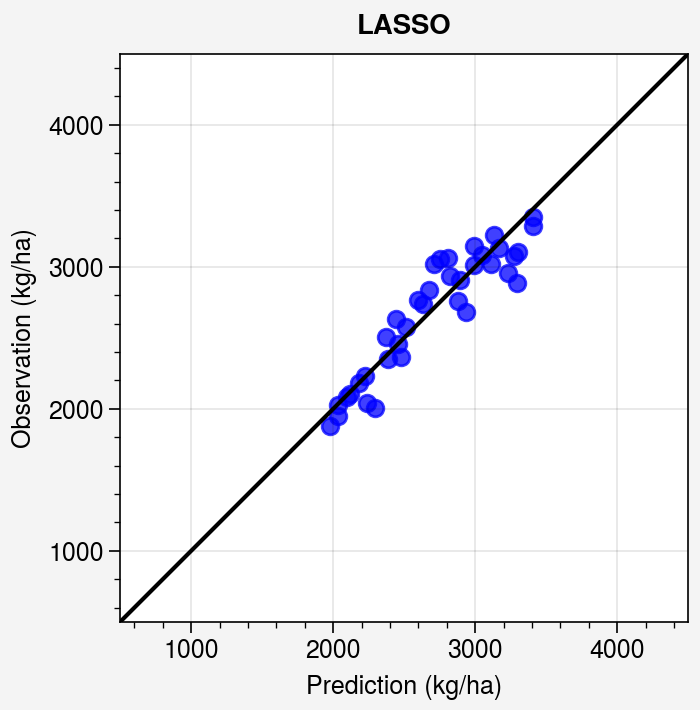

In [59]:
# Plot the predictions vs observations
fig, ax = pplt.subplots(ncols=1, nrows=1, refaspect=1.0, journal='nat1', suptitle='LASSO')

plot = sns.regplot(ax=ax, x=predictions, y=state_soyb, line_kws={'color':'blue', 'lw':0}, scatter_kws={'alpha':0.75, 'color':'blue'}, ci=None)

# # 1:1 line in the entire range
min_val = 500  # Use the entire range defined in ax.format()
max_val = 4500  # Use the entire range defined in ax.format() 
ax.plot([min_val, max_val], [min_val, max_val], 'k-', alpha=1.0)

ax.format(xlabel='Prediction (kg/ha)', ylabel='Observation (kg/ha)', xlim=[min_val, max_val], ylim=[min_val, max_val], xlocator=1000, ylocator=1000)

# Bootstrapping Simulations

In [60]:
# 1. Define the function for bootstrap iteration
def process_bootstrap(X, y):
    """Each bootstrap iteration is executed in this function
    
    Parameters:
    X: array-like, the feature data
    y: array-like, the target data
    """
    n_samples = int(len(X) * 1)
    indices = np.random.choice(len(X), size=n_samples, replace=True)
    X_resampled = X.iloc[indices]
    y_resampled = y.iloc[indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, 
        test_size=0.3, 
        random_state=20
    )

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    lasso_cv = LassoCV(
        alphas=np.logspace(-4, 1, 100),
        cv=10, 
        random_state=20, 
        max_iter=1000  
    )
    lasso_cv.fit(X_train, y_train)
    
    model_best = Lasso(
        alpha=lasso_cv.alpha_,
        max_iter=1000 
    )
    result = model_best.fit(X_train, y_train)
    
    coefs = result.coef_
    intercept = result.intercept_
    r2_train = round(model_best.score(X_train, y_train)*100, 2)
    r2_test  = round(model_best.score(X_test, y_test)*100, 2)

    scales = scaler.scale_
    means = scaler.mean_
    
    original_coefs = coefs / scales
    original_intercept = intercept - np.sum(means * coefs / scales) 
    
    return original_coefs, original_intercept, [r2_train, r2_test]

# 2. Use parallel processing in the main loop
def process_state(X, y, n_iterations):
    """Process the data of one state
    
    Parameters:
    state: str, state name
    X: array-like, feature data
    y: array-like, target data 
    n_iterations: int, number of bootstrap iterations
    
    Returns:
    coefs: array, coefficients from all iterations
    intercepts: array, intercepts from all iterations 
    r2s: array, R2 scores from all iterations
    """
    results = Parallel(n_jobs=-1)(
        delayed(process_bootstrap)(X, y) 
        for n in range(n_iterations)
    )
    
    coefs = np.array([r[0] for r in results])
    intercepts = np.array([r[1] for r in results])
    r2s = np.array([r[2] for r in results])
    
    return coefs, intercepts, r2s

In [61]:
# 3. Main Functions
n_iterations = 1000

for state in agricultural_states:
        
        print('*****', state, '*****')

        # Prepare data
        state_soyb = soyb[state]
        state_prec = align_data_with_growth(prec[state], 'P')
        state_temp = align_data_with_growth(temp[state], 'T')
        state_feature = crop_growth_period(state_prec, state_temp)
        
        # Parallel processing bootstrap
        X = state_feature.copy()
        y = state_soyb

        Coefs, Intercepts, R2s = process_state(X, y, n_iterations=n_iterations) 

        # Save the results
        pd.DataFrame(R2s, columns=['Train', 'Test']).to_csv(f'./model_outputs/statistics_{state}_R2_soybean_dependency_on_climate.csv', index=False)
        pd.DataFrame(Coefs, columns=state_feature.columns).to_csv(f'./model_outputs/statistics_{state}_Coef_soybean_dependency_on_climate.csv', index=False)
        pd.DataFrame(Intercepts, columns=['Intercept']).to_csv(f'./model_outputs/statistics_{state}_Intercept_soybean_dependency_on_climate.csv', index=False)

***** BR43 *****
***** BR42 *****
***** BR41 *****
***** BR35 *****
***** BR50 *****
***** BR53 *****
***** BR51 *****


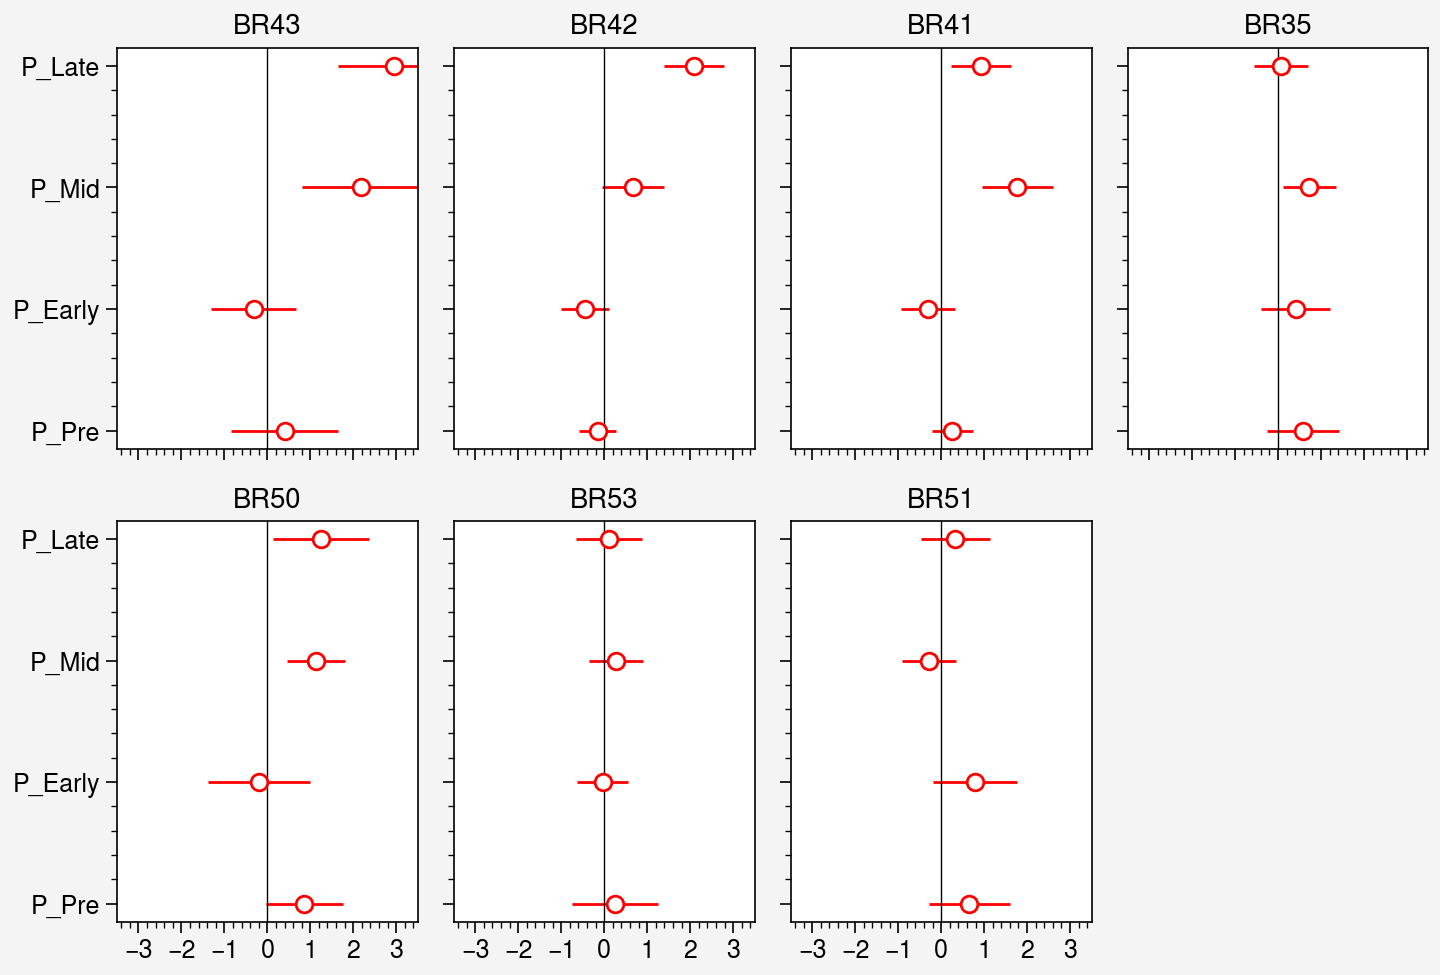

In [62]:
# Plot coefficients with confidence intervals
fig, axs = pplt.subplots(ncols=4, nrows=2, refaspect=0.75, journal='nat2')
axs[-1].set_visible(False)

threshold_freq = 0.5

for i, state in enumerate(agricultural_states):
    # Load and filter data
    Coefs = pd.read_csv('./model_outputs/' + 'statistics_' + state + '_Coef_soybean_dependency_on_climate.csv')
    #R2s = pd.read_csv('./model_outputs/' + 'statistics_' + state + '_R2_soybean_dependency_on_climate.csv')
    #Coefs = Coefs[R2s['Test'] >= 0]
    
    # Calculate statistics
    selection_freq = (Coefs != 0).mean()
    stable_vars = selection_freq[selection_freq > threshold_freq].index
    
    mean = Coefs.iloc[:, :-3].mean()  # Exclude last 3 columns
    std_err = Coefs.iloc[:, :-3].std() / 2 #np.sqrt(len(Coefs))
    ci_low, ci_high = stats.norm.interval(0.95, mean, std_err)
    
    # Plot
    ax = axs[i]
    x = np.arange(len(mean))
    
    ax.errorbar(y=x, x=mean, xerr=[(mean - ci_low), (ci_high - mean)],
                fmt='o', color='r', ms=6, mfc='white', 
                capsize=0, capthick=1, lw=1)
    
    ax.set_yticks(x)
    ax.set_yticklabels(Coefs.columns[:-3])
    ax.axvline(x=0, color='k', ls='-', lw=0.5)
    ax.format(title=agricultural_states[i], xlim=[-3.5,3.5], xlocator=1, grid=False)

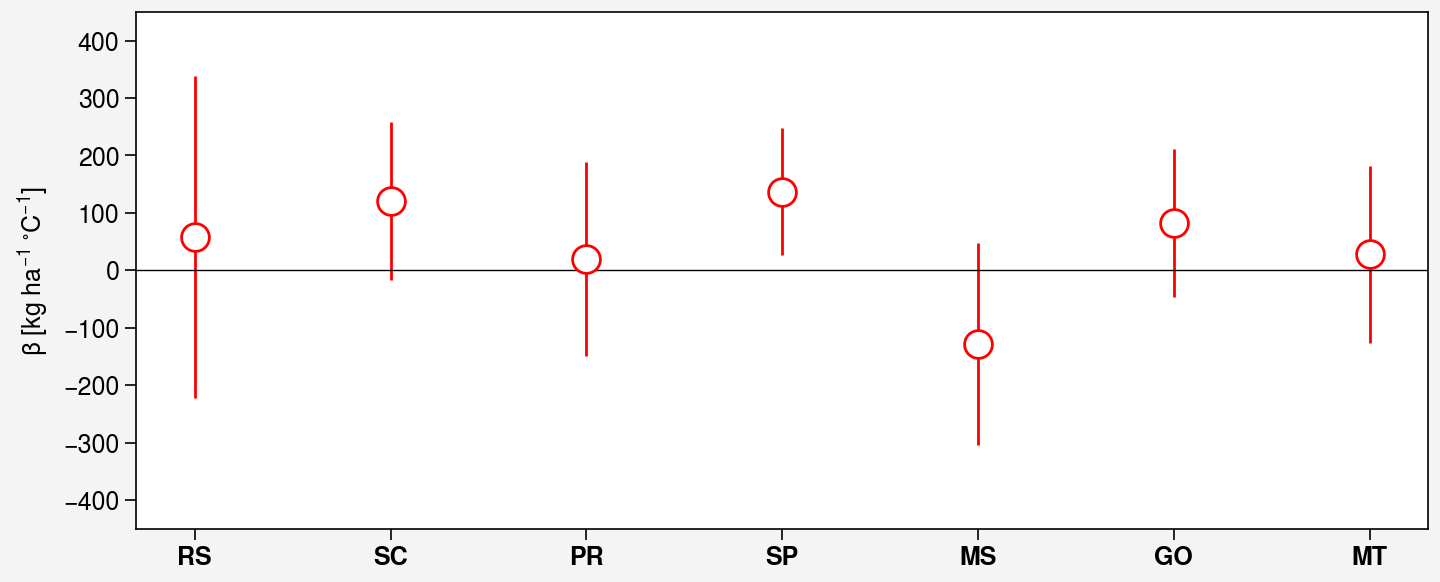

In [69]:
fig, ax = pplt.subplots(ncols=1, nrows=1, refaspect=2.5, journal='nat2',      )

for i, state in enumerate(agricultural_states):
    # Load and filter data
    Coefs = pd.read_csv('./model_outputs/'  + 'statistics_' + state + '_Coef_soybean_dependency_on_climate.csv')
    
    # Calculate statistics
    selection_freq = (Coefs != 0).mean()
    stable_vars = selection_freq[selection_freq > threshold_freq].index
    
    mean = Coefs['Grow_T'].mean()  # Exclude last 3 columns
    std_err = Coefs['Grow_T'].std() / 2 #/ np.sqrt(len(Coefs))
    ci_low, ci_high = stats.norm.interval(0.95, mean, std_err)

    # Plot
    x = i * 5
    
    ax.errorbar(y=mean, x=x, yerr=Coefs['Grow_T'].std(),
                fmt='o', color='r', ms=10, mfc='white', 
                capsize=0, capthick=1, lw=1)
    

state_positions = [i * 5 for i in range(len(agricultural_states))]
ax.set_xticks(state_positions); ax.minorticks_off()
ax.set_xticklabels(agricultural_abbres, rotation=0, weight='bold');
ax.axhline(y=0, color='k', ls='-', lw=0.5)
ax.format(grid=False, ylim=[-450,450], ylabel=r'$\beta$ [kg ha$^{-1}$ $^{\circ}$C$^{-1}$]')

# Export the figure
fig.save('./figures/Supplementary/Supplementary_Temperature_Sensitivity.png', dpi=600, bbox_inches='tight')

***** BR43 *****
0.7176362718505449
***** BR42 *****
0.9186936861982079
***** BR41 *****
0.7998615819627426
***** BR35 *****
0.8215649262157483
***** BR50 *****
0.7596946561845925
***** BR53 *****
0.834922569936049
***** BR51 *****
0.8647150601928147


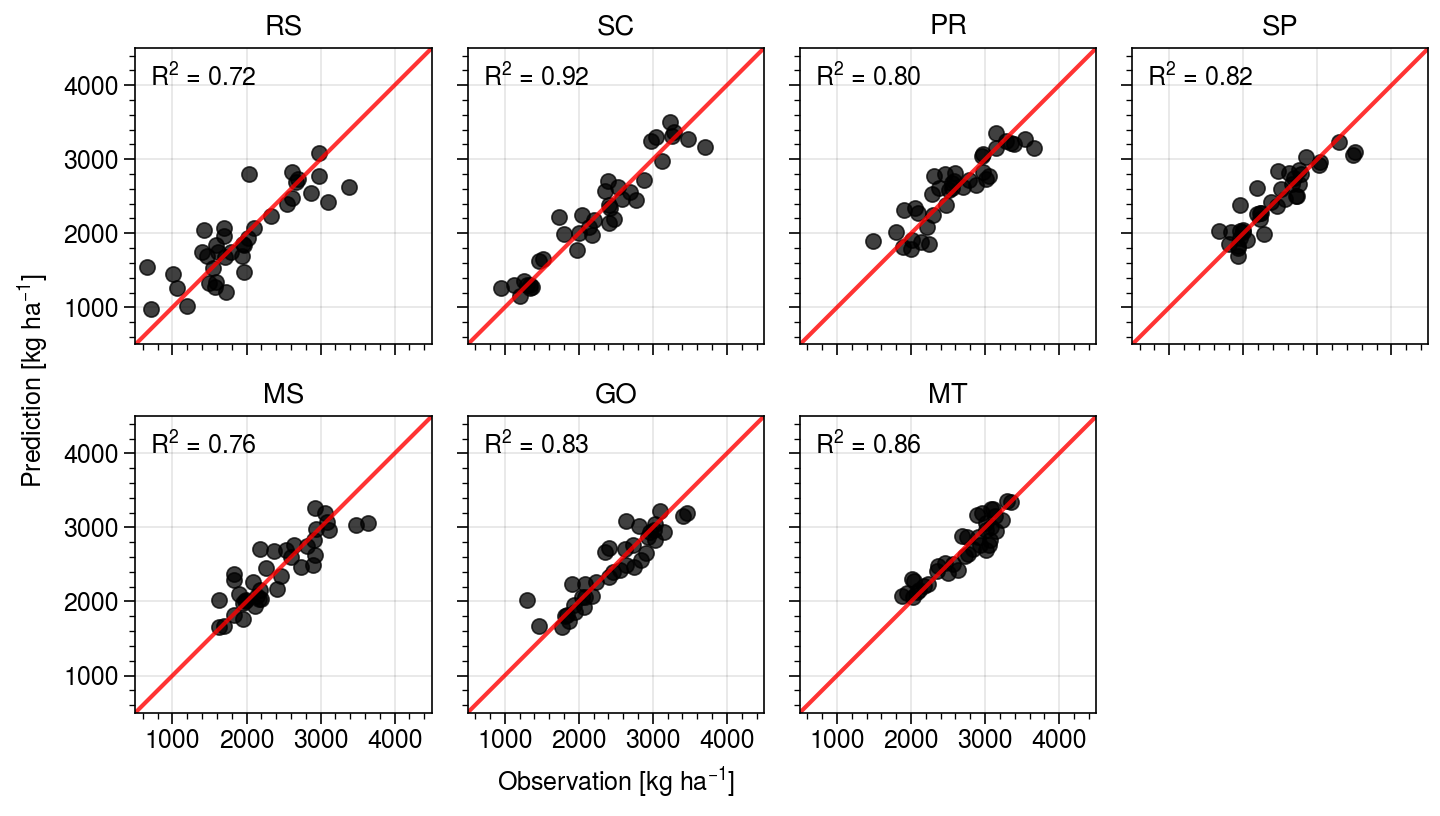

In [67]:
# Create the figure 
fig, axs = pplt.subplots(ncols=4, nrows=2, refaspect=1.0, journal='nat2', facecolor='#ffffff')
axs[-1].set_visible(False)

# Initialize list to store R2 scores
r2_scores = []

for i, state in enumerate(agricultural_states):

    print('*****', state, '*****')
    
    # Load data
    Coefs = pd.read_csv('./model_outputs/' +  'statistics_' + state + '_Coef_soybean_dependency_on_climate.csv')
    Intercepts = pd.read_csv('./model_outputs/' +  'statistics_' + state + '_Intercept_soybean_dependency_on_climate.csv')
    
    # Prepare observations
    state_soyb = soyb[state]
    state_prec = align_data_with_growth(prec[state], 'P')
    state_temp = align_data_with_growth(temp[state], 'T')
    state_feature = crop_growth_period(state_prec, state_temp)
    
    #! Calculate predictions using mean coefficients and intercepts
    mean_coefs = Coefs.mean() # mean coefficients of all iterations
    mean_intercept = Intercepts.mean() # mean intercept of all iterations
    
    predictions = (
        mean_coefs[0] * state_feature['P_Pre'] + 
        mean_coefs[1] * state_feature['P_Early'] + 
        mean_coefs[2] * state_feature['P_Mid'] + 
        mean_coefs[3] * state_feature['P_Late'] + 
        mean_coefs[4] * state_feature['Grow_T'] + 
        mean_coefs[5] * state_feature['Year'] + 
        mean_coefs[6] * state_feature['Year_sq'] + 
        mean_intercept.values[0]  # Use values[0] to get scalar value
    )
    
    observations = state_soyb
    
    # Calculate R2 score
    r2 = r2_score(observations, predictions)
    r2_scores.append(r2)
    
    # Plot
    ax = axs[i]
    
    ax.scatter(observations.values, predictions.values, color='k', alpha=0.75, s=30)
    
    # Add R2 text
    ax.text(0.05, 0.95, f'R$^{2}$ = {r2:.2f}', transform=ax.transAxes, 
            verticalalignment='top')
    
    # # 1:1 line in the entire range
    min_val = 500  # Use the entire range defined in ax.format()
    max_val = 4500  # Use the entire range defined in ax.format() 
    ax.plot([min_val, max_val], [min_val, max_val], 'r-', alpha=0.8)
    
    ax.format(title=agricultural_abbres[i], 
              xlabel='Observation [kg ha$^{-1}$]', 
              ylabel='Prediction [kg ha$^{-1}$]',
              xlocator=1000, ylocator=1000, xlim=(min_val, max_val), ylim=(min_val, max_val))

    
    # Calculate R2 score
    observations = state_soyb
    r2 = r2_score(observations, predictions)
    # r = np.corrcoef(observations, predictions)[0,1]
    # r2 = r**2

    print(r2)

# Export the r2_scores
pd.DataFrame(r2_scores, columns=['R2']).to_csv('./model_outputs/statistics_r2_scores_predictions.csv', index=False)

# Export the figure
fig.save('./figures/Supplementary/Supplementary_Observations_vs_Predictions.png', dpi=600, bbox_inches='tight')

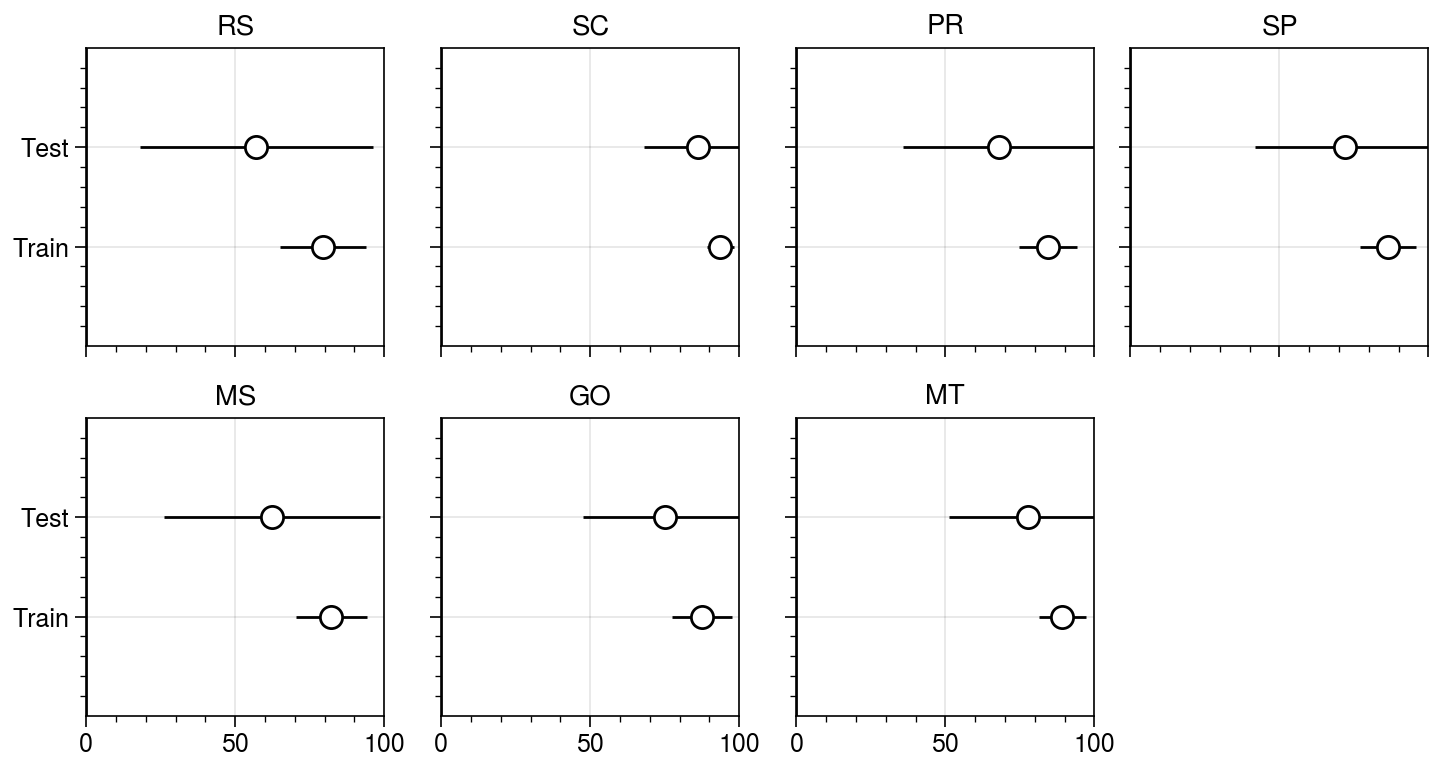

In [68]:
# Create the figure 
fig, axs = pplt.subplots(ncols=4, nrows=2, refaspect=1, journal='nat2', facecolor='#ffffff')
axs[-1].set_visible(False)

for i, state in enumerate(agricultural_states):
    
    # load data
    Coefs = pd.read_csv('./model_outputs/' + 'statistics_' + state + '_Coef_soybean_dependency_on_climate.csv')
    R2s = pd.read_csv('./model_outputs/' + 'statistics_' + state + '_R2_soybean_dependency_on_climate.csv')

    # Filter out interactions with negative test R2
    valid_rows = R2s['Test'] >= 0
    Coefs = Coefs[valid_rows]
    R2s = R2s[valid_rows]

    # --- Calculate the confidence interval
    # the sample mean and standard deviation, sampling numbers
    mean     = R2s.mean(axis=0)
    std_err  = R2s.std(axis=0, ddof=1) #np.sqrt(len(Coefs))
    ci_low, ci_high = stats.norm.interval(0.95, mean, std_err)

    # --- Plot the figure
    ax = axs[i]

    x = np.arange(0, 2)
    y = mean
    # Calculate asymmetric error bars
    yerr = [mean - ci_low, ci_high - mean]

    ax.errorbar(x=y, y=x, xerr=yerr, fmt='o', mfc='white', ms=8, lw=1, capsize=2, capthick=0, color='k', ecolor='k')

    ax.set_yticks(x)
    ax.set_yticklabels(R2s.columns.to_list())

    ax.axvline(x=0, color='k', ls='-', lw=1)

    ax.format(title=agricultural_abbres[i], xlim=[0,100], ylim=[-1,2], xlocator=50)

# Export the figure
fig.save('./figures/Supplementary/Supplementary_Train_and_Test_R2.png', dpi=600, bbox_inches='tight')